In [ ]:
#电量数据进行季节性调整处理

import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import seaborn as sns

# --- 环境设置 ---
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ==============================================================================
# 0. 参数配置
# ==============================================================================
file_path = r'E:\A智网\业扩分析\8月分析\重点行业电量.xlsx'
sheet_name = '电量'
output_path = r'E:\A智网\业扩分析\8月分析\重点行业电量_季节性调整后_FINAL.xlsx'

print("--- 最终修复版程序开始 ---")

# ==============================================================================
# 1. 加载数据并进行初步清洗
# ==============================================================================
print("\n--- 步骤 1: 加载数据与初步清洗 ---")
try:
    df_wide = pd.read_excel(file_path, sheet_name=sheet_name)
    print(f"成功加载Excel。原始形状: {df_wide.shape}")
except Exception as e:
    print(f"!!! 致命错误: 加载Excel失败: {e}")
    exit()

# 备份信息列
df_info = df_wide[['序号', '分类']].copy()

# 提取时间序列部分
df_ts = df_wide.drop(columns=['序号', '分类'])

# --- 关键修复：处理列名 ---
# 将列名强制转换为字符串，并去除可能存在的'.0'
df_ts.columns = df_ts.columns.astype(str).str.replace(r'\.0$', '', regex=True)
print("列名已清洗 (强制转为字符串并去除'.0')。")
print(f"清洗后的列名 (前5个): {df_ts.columns[:5].tolist()}")

# ==============================================================================
# 2. 逐行处理与STL分解
# ==============================================================================
print("\n--- 步骤 2: 逐行进行STL分解 ---")

# 创建一个空的列表来收集处理好的行（作为Series）
processed_rows_list = []

for index in df_ts.index:
    category_name = df_info.loc[index, '分类']
    print(f"\n  --- 正在处理索引 {index}, 分类: '{category_name}' ---")
    
    # 从df_ts中提取当前行
    original_row = df_ts.loc[index]

    # 将行数据转换为带时间索引的Series
    try:
        # 强制将数据转换为数值，并用0填充缺失值
        ts_data = pd.to_numeric(original_row, errors='coerce').fillna(0)
        
        # 创建时间序列
        ts = pd.Series(
            ts_data.values,
            index=pd.to_datetime(ts_data.index, format='%Y%m')
        )
        print("    数据已成功转换为时间序列。")
    except Exception as e:
        print(f"    !!! 错误: 无法将行数据转换为时间序列: {e}. 跳过此行。")
        continue # 跳到下一个循环

    # STL分解
    try:
        if len(ts) < 25 or ts.std() < 1e-6:
            seasonal_adjusted_series = ts
            print("    STL跳过 (数据不足或无波动)，使用原始数据。")
        else:
            stl = STL(ts, period=12, robust=True)
            res = stl.fit()
            seasonal_adjusted_series = res.trend + res.resid
            print("    STL分解成功。")
            
    except Exception as e:
        seasonal_adjusted_series = ts
        print(f"    !!! 警告: STL分解失败: {e}。使用原始数据作为备用。")

    # 将处理好的一行数据添加到列表中
    processed_rows_list.append(seasonal_adjusted_series)
    print(f"    已将处理好的序列添加到结果列表。")

print("\n--- 循环结束 ---")

# ==============================================================================
# 3. 重构DataFrame并保存
# ==============================================================================
print("\n--- 步骤 3: 重构DataFrame并保存 ---")

if not processed_rows_list:
    print("!!! 致命错误: 循环处理后，结果列表为空。程序终止。")
    exit()

print(f"结果列表中有 {len(processed_rows_list)} 行数据，准备重构DataFrame。")

try:
    # 使用列表构建DataFrame，更安全
    df_seas_adj = pd.DataFrame(processed_rows_list)
    
    # 恢复原始的行索引
    df_seas_adj.index = df_ts.index
    
    # 将列名（datetime对象）转换回'YYYYMM'字符串格式
    df_seas_adj.columns = df_seas_adj.columns.strftime('%Y%m')

    print(f"成功构建季节性调整后的DataFrame。形状: {df_seas_adj.shape}")

    # 合并信息列和数据列
    df_output = pd.concat([df_info, df_seas_adj], axis=1)
    
    # 保存到Excel
    df_output.to_excel(output_path, sheet_name='季节性调整后电量', index=False)
    print(f"\n处理成功！结果已保存到: {output_path}")

except Exception as e:
    print(f"!!! 致命错误: 在重构或保存DataFrame时发生错误: {e}")

print("\n--- 程序执行完毕 ---")


# (可选) 可视化对比
try:
    if not df_ts.empty:
        random_index = df_ts.sample(1).index[0]
        category_to_plot = df_info.loc[random_index, '分类']

        original_ts = pd.to_numeric(df_ts.loc[random_index], errors='coerce')
        original_ts.index = pd.to_datetime(original_ts.index, format='%Y%m')

        adjusted_ts = pd.to_numeric(df_output.drop(columns=['序号', '分类']).loc[random_index], errors='coerce')
        adjusted_ts.index = pd.to_datetime(adjusted_ts.index, format='%Y%m')

        plt.figure(figsize=(15, 6))
        plt.plot(original_ts, label=f'原始数据 - {category_to_plot}', alpha=0.7)
        plt.plot(adjusted_ts, label=f'STL季节性调整后 - {category_to_plot}', color='red', linewidth=2)
        plt.title('随机抽样行业：原始 vs. 季节性调整后对比', fontsize=16)
        plt.legend()
        plt.grid(True)
        plt.show()
except Exception as e:
    print(f"\n可视化部分出错: {e}")

In [ ]:
#初步CCF分析

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re # 导入正则表达式库
from statsmodels.tsa.stattools import ccf

# --- 环境设置 ---
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ==============================================================================
# 0. 参数配置
# ==============================================================================
file_path = r'E:\A智网\业扩分析\8月分析\8.1分析数据.xlsx'
sheet_map = {
    'kwh': '电量', # 假设这是处理后的 d_kwh
    'cap_high_new': '高压新装容量',
    'cap_high_exp': '高压增容容量',
    'cap_low_new': '低压新装容量',
    'cap_low_exp': '低压增容容量'
}

# ==============================================================================
# 1. 一次性加载所有已处理好的数据 (带列清洗修复)
# ==============================================================================
print("--- 步骤 1: 正在加载并清洗数据 ---")
all_data_wide = {}
try:
    for var_name, sheet_name in sheet_map.items():
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        
        # --- 关键修复：清洗无效列 ---
        # 使用正则表达式筛选出所有由6位数字组成的列名
        # `\d{6}` 匹配6个数字, `^`和`$`确保整列名称就是6个数字
        valid_date_columns = [col for col in df.columns if isinstance(col, str) and re.match(r'^\d{6}$', col)]
        # 兼容列名是数字（如201801）的情况
        numeric_date_columns = [str(col) for col in df.columns if isinstance(col, (int, float)) and len(str(int(col))) == 6]
        
        # 最终保留的列 = 基础信息列 + 所有有效的日期列
        columns_to_keep = ['序号', '分类'] + valid_date_columns + numeric_date_columns
        
        # 只选择这些有效的列，丢弃 "Unnamed: ..." 等无效列
        df_cleaned = df[columns_to_keep]
        
        # --- 后续处理与您的代码相同 ---
        df_cleaned.columns = df_cleaned.columns.astype(str).str.replace(r'\.0$', '', regex=True)
        df_cleaned.set_index('分类', inplace=True)
        all_data_wide[var_name] = df_cleaned.drop(columns='序号')
        print(f"  成功加载并清洗 Sheet: '{sheet_name}'，保留了 {len(df_cleaned.columns)-2} 个有效日期列。")

except Exception as e:
    raise RuntimeError(f"加载或清洗数据时出错: {e}")

# 获取所有唯一的行业名称列表
industry_list = all_data_wide['kwh'].index.unique().tolist()
print(f"\n将对以下 {len(industry_list)} 个行业进行独立分析。")

# ==============================================================================
# 2. 主循环：分行业进行CCF分析 (您的代码，无需修改)
# ==============================================================================
print("\n--- 步骤 2: 开始分行业CCF分析 ---")
all_industries_lags = {} # 用于存储所有行业的最终结果

for industry_name in industry_list:
    print(f"\n{'='*25} 正在分析行业: {industry_name} {'='*25}")
    
    # --- 2.1 为当前行业构建专属数据集 ---
    industry_df = pd.DataFrame()
    for var_name, df_wide in all_data_wide.items():
        if industry_name in df_wide.index:
            series_raw = df_wide.loc[industry_name]
            # 转换为带时间索引的Series
            ts = pd.Series(
                pd.to_numeric(series_raw, errors='coerce').fillna(0).values,
                index=pd.to_datetime(series_raw.index, format='%Y%m'),
                name=var_name
            )
            industry_df[var_name] = ts
        else:
            print(f"    警告: 在 {sheet_map[var_name]} sheet中未找到行业 '{industry_name}'")
            
    # 检查数据是否完整
    if industry_df.empty or 'kwh' not in industry_df.columns or len(industry_df.columns) < 5:
        print("    -> 数据不完整，跳过此行业分析。")
        continue
    
    # 清理因日期不对齐可能产生的NaN
    industry_df.dropna(inplace=True)
    
    if len(industry_df) < 25:
        print("    -> 数据点不足 (< 25)，无法进行有效CCF分析，跳过。")
        continue

    # --- 2.2 对当前行业的数据进行CCF分析 ---
    industry_lags = {}
    target_var = 'kwh' # 使用 'kwh' 作为因变量名
    exog_vars = [col for col in industry_df.columns if col != target_var]
    
    print("    正在计算交叉相关性...")
    for var in exog_vars:
        ccf_values = ccf(industry_df[target_var], industry_df[var], adjusted=False)
        # 您代码中的 max_lag_to_check = 8
        max_lag_to_check = 8
        relevant_lags = range(1, max_lag_to_check + 1)
        relevant_ccf_values = ccf_values[1 : max_lag_to_check + 1]
        
        if len(relevant_ccf_values) > 0 and np.any(relevant_ccf_values):
            best_lag_index = np.argmax(np.abs(relevant_ccf_values))
            best_lag = relevant_lags[best_lag_index]
        else:
            best_lag = 0 # 如果没有相关性，滞后期为0
        industry_lags[var] = best_lag

    all_industries_lags[industry_name] = industry_lags
    print(f"    -> 分析完成。滞后结果: {industry_lags}")

# ==============================================================================
# 3. 最终结果汇总 (您的代码，无需修改)
# ==============================================================================
print(f"\n{'='*30} 所有行业分析结果汇总 {'='*30}")

if not all_industries_lags:
    print("未能完成任何行业的分析。")
else:
    # 将嵌套字典转换为DataFrame方便查看
    df_summary = pd.DataFrame.from_dict(all_industries_lags, orient='index')
    
    # 确保列的顺序是我们期望的
    final_columns = ['cap_high_new', 'cap_high_exp', 'cap_low_new', 'cap_low_exp']
    df_summary = df_summary.reindex(columns=final_columns)
    
    df_summary.index.name = '行业分类'
    df_summary.columns.name = '业扩指标'
    print("各行业业扩指标对电量增量的最佳影响滞后期（月）:")
    print(df_summary)
    
    # (可选) 保存汇总结果到Excel
    summary_output_path = r'E:\A智网\业扩分析\8月分析\业扩CCF分析结果.xlsx'
    df_summary.to_excel(summary_output_path)
    print(f"\n汇总结果已保存到: {summary_output_path}")

print("\n--- 全部分析任务完成 ---")

In [37]:
#残余噪音分析

# Cell 1: 导入库与参数配置
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# --- 环境设置 ---
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# --- 参数配置 ---
file_path = r'E:\A智网\业扩分析\8月分析\重点行业业扩数据0806.xlsx'
sheet_map = {
    'kwh': '电量',
    'cap_high_new': '高压新装',
    'cap_high_exp': '高压增容',
    'cap_low_new': '低压新装',
    'cap_low_exp': '低压增容'
}

In [38]:
# Cell 2: 加载所有已处理好的数据
print("--- 正在加载所有已处理好的数据 ---")
all_data_wide = {}
try:
    for var_name, sheet_name in sheet_map.items():
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        df.columns = df.columns.astype(str).str.replace(r'\.0$', '', regex=True)
        df.set_index('分类', inplace=True)
        all_data_wide[var_name] = df.drop(columns='序号')
        print(f"  成功加载 Sheet: '{sheet_name}'")
except Exception as e:
    raise RuntimeError(f"加载数据时出错: {e}")

industry_list = all_data_wide['kwh'].index.unique().tolist()
print(f"\n数据加载完成，共 {len(industry_list)} 个行业。")

--- 正在加载所有已处理好的数据 ---
  成功加载 Sheet: '电量'
  成功加载 Sheet: '高压新装'
  成功加载 Sheet: '高压增容'
  成功加载 Sheet: '低压新装'
  成功加载 Sheet: '低压增容'

数据加载完成，共 23 个行业。



========================= 正在诊断行业: B、城乡居民生活用电合计 =========================


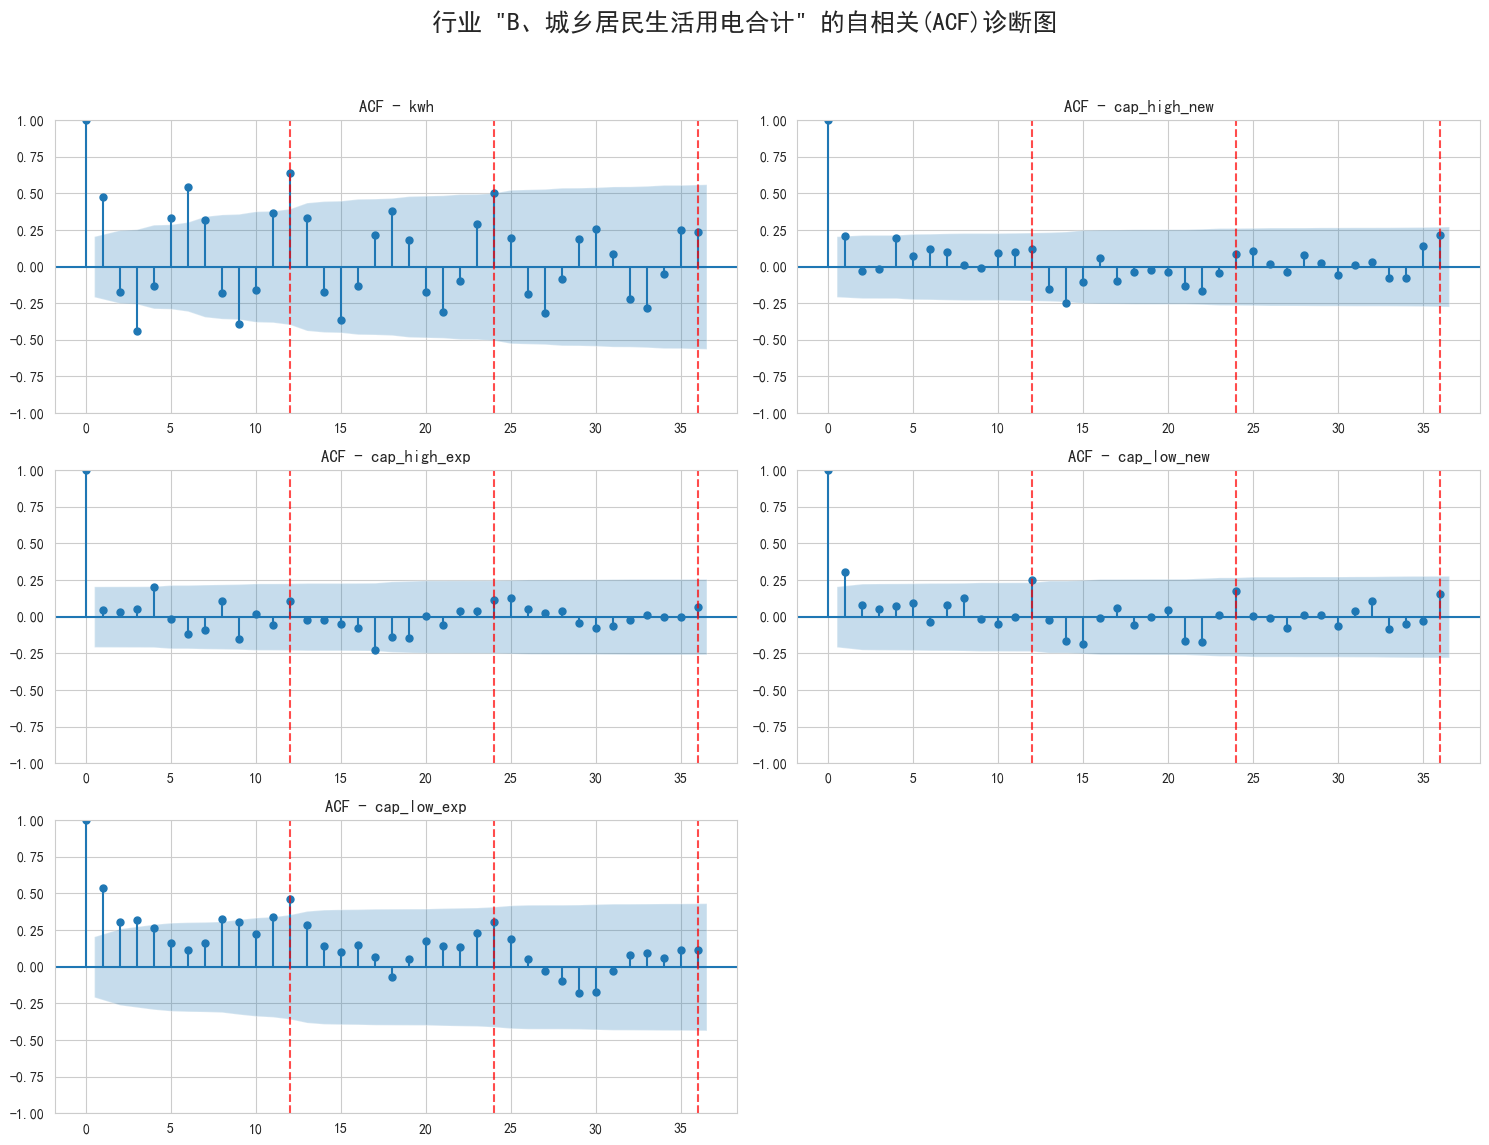


========================= 正在诊断行业: 十一、公共服务及管理组织 =========================


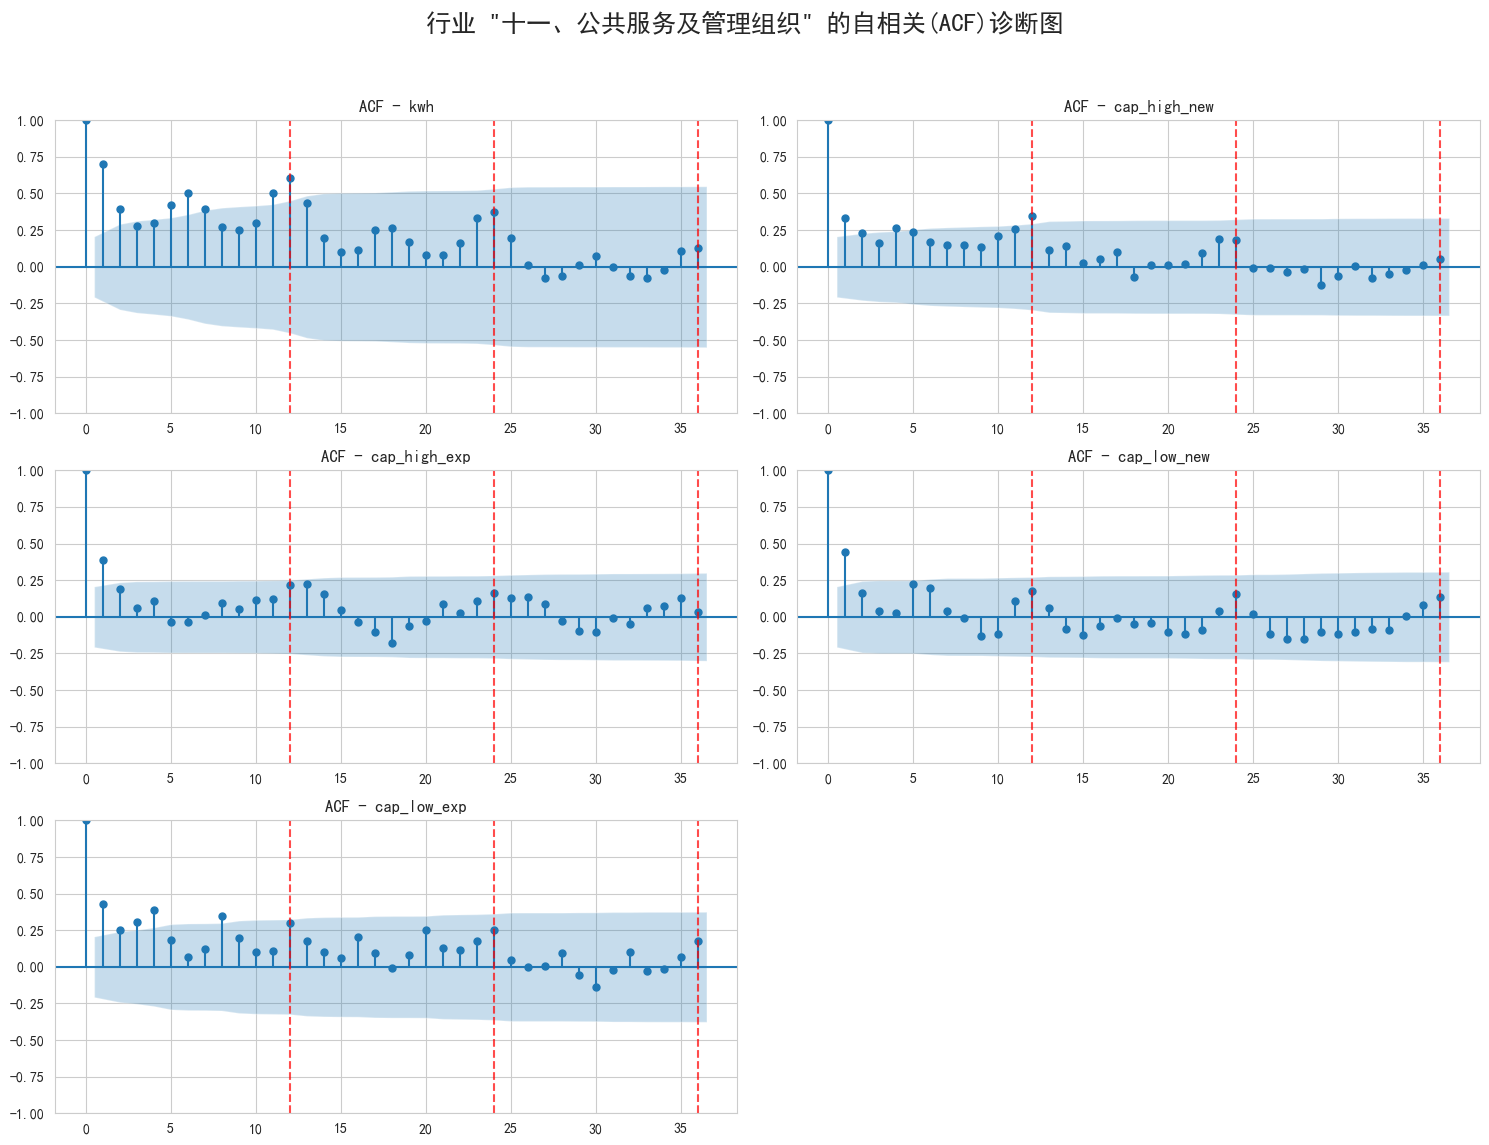


========================= 正在诊断行业:     14.化学原料和化学制品制造业 =========================


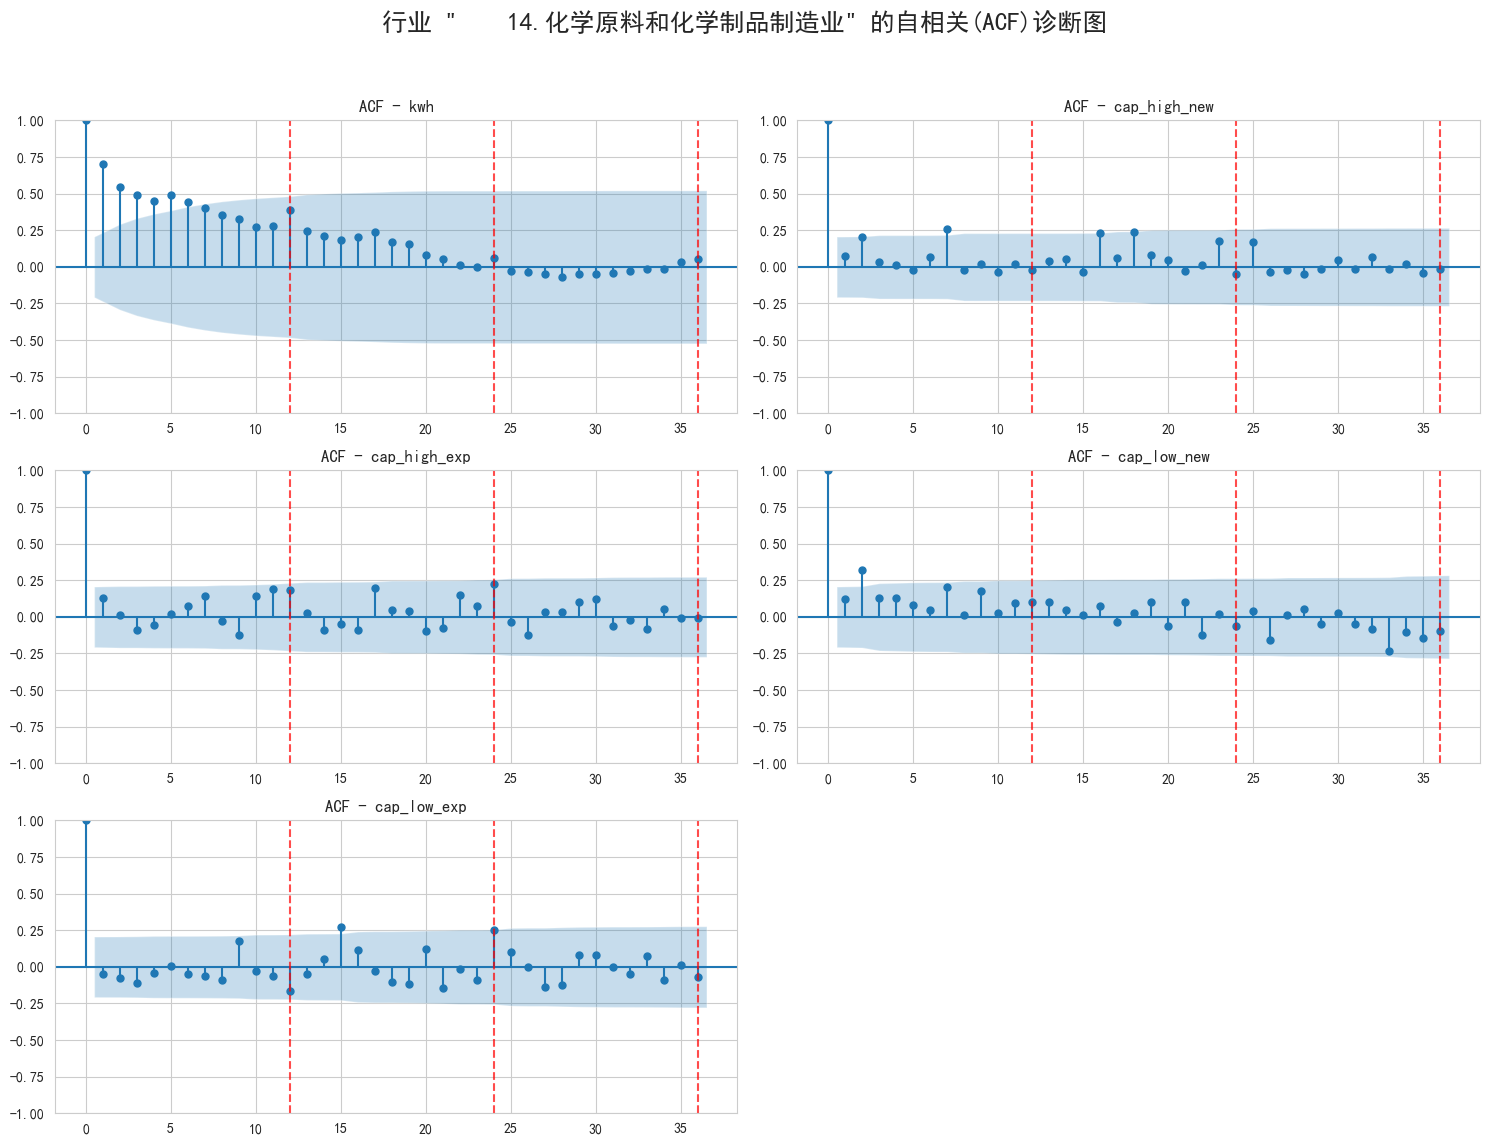


========================= 正在诊断行业:     27.计算机、通信和其他电子设备制造业 =========================


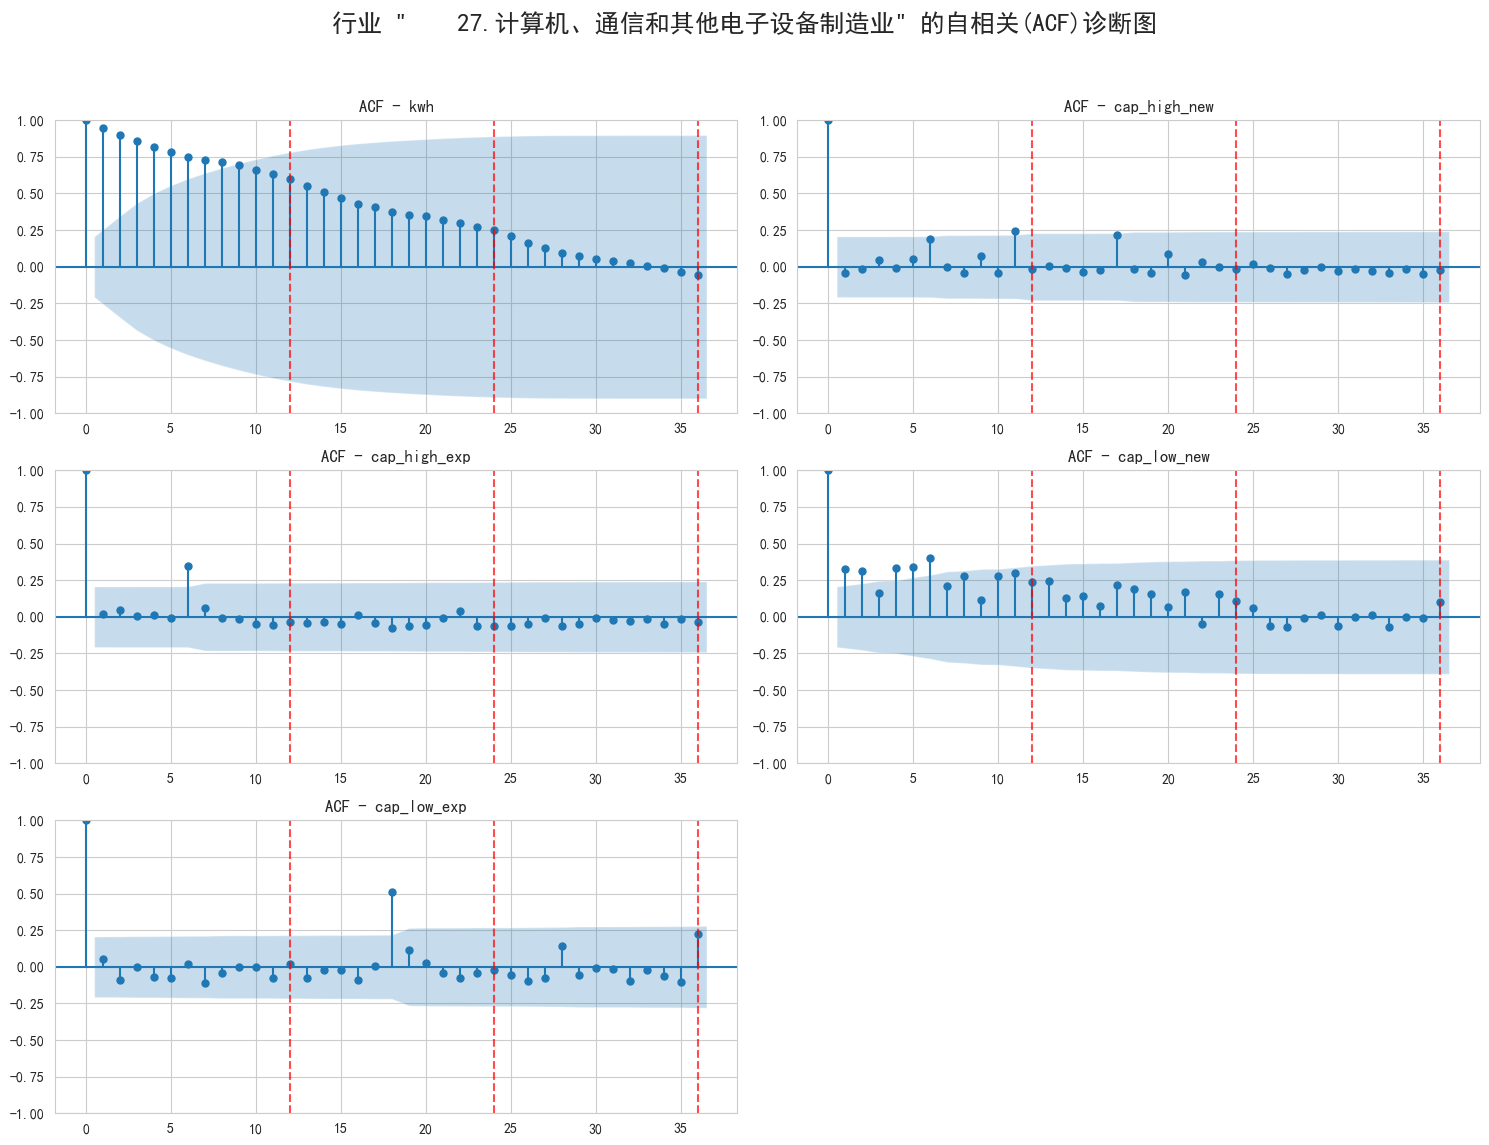


========================= 正在诊断行业: 七、住宿和餐饮业 =========================


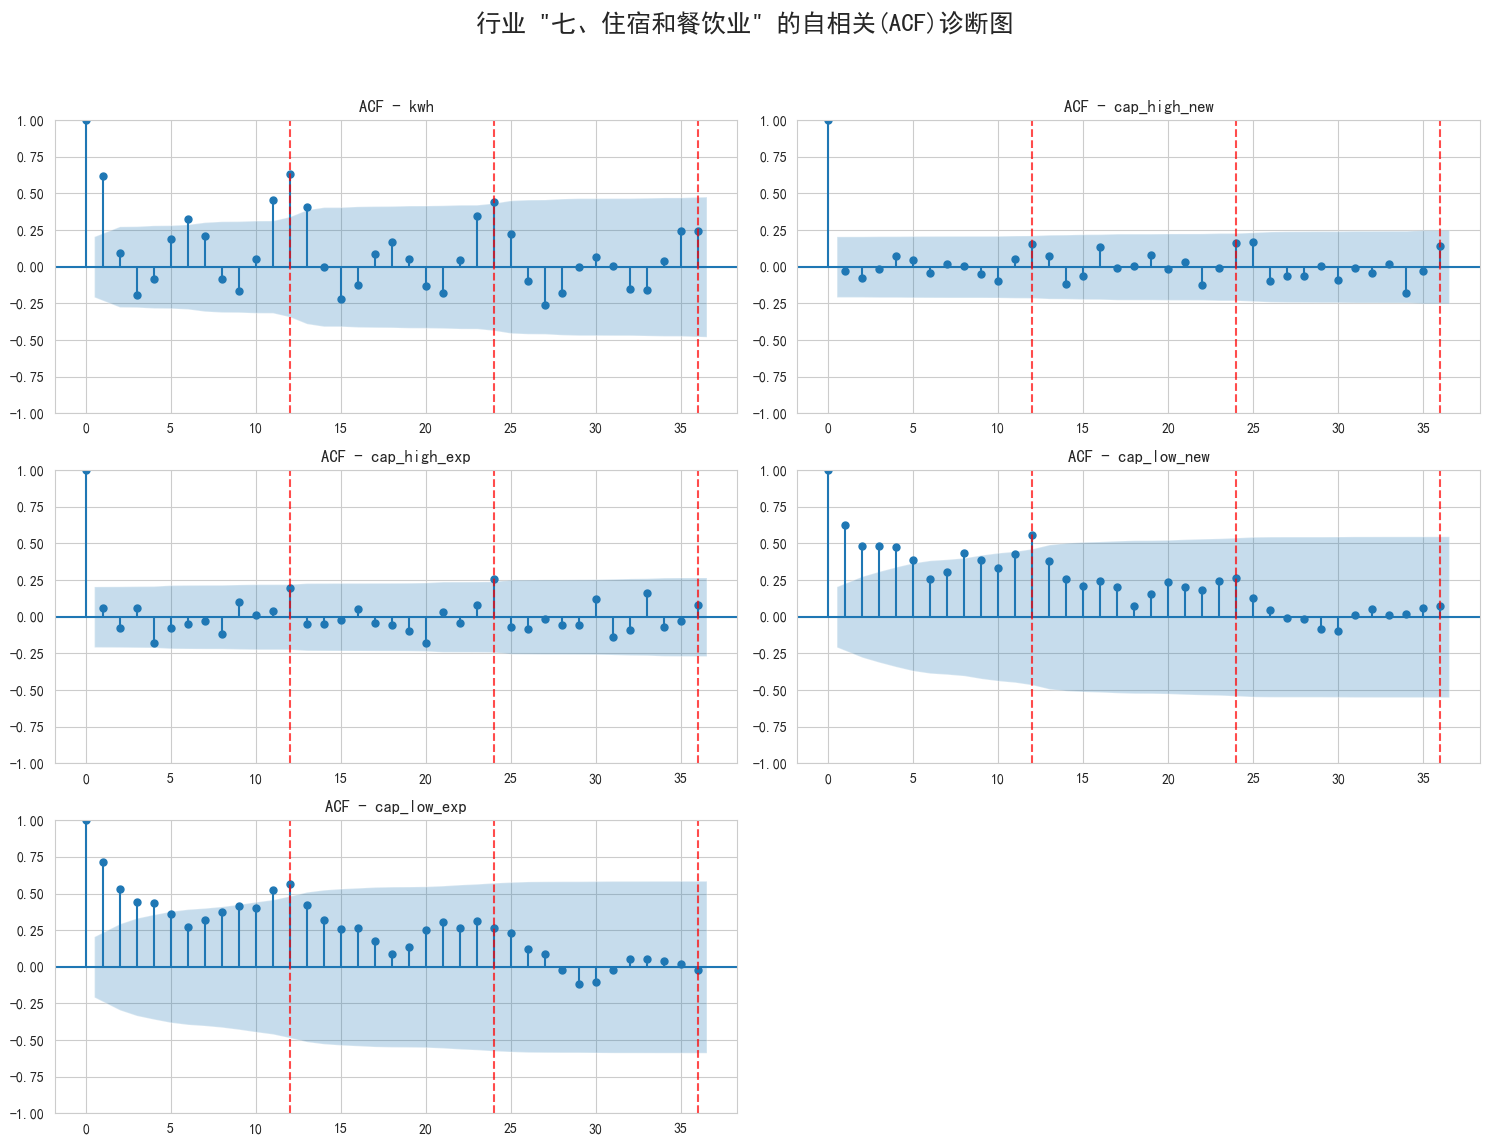


========================= 正在诊断行业: 十、租赁和商务服务业 =========================


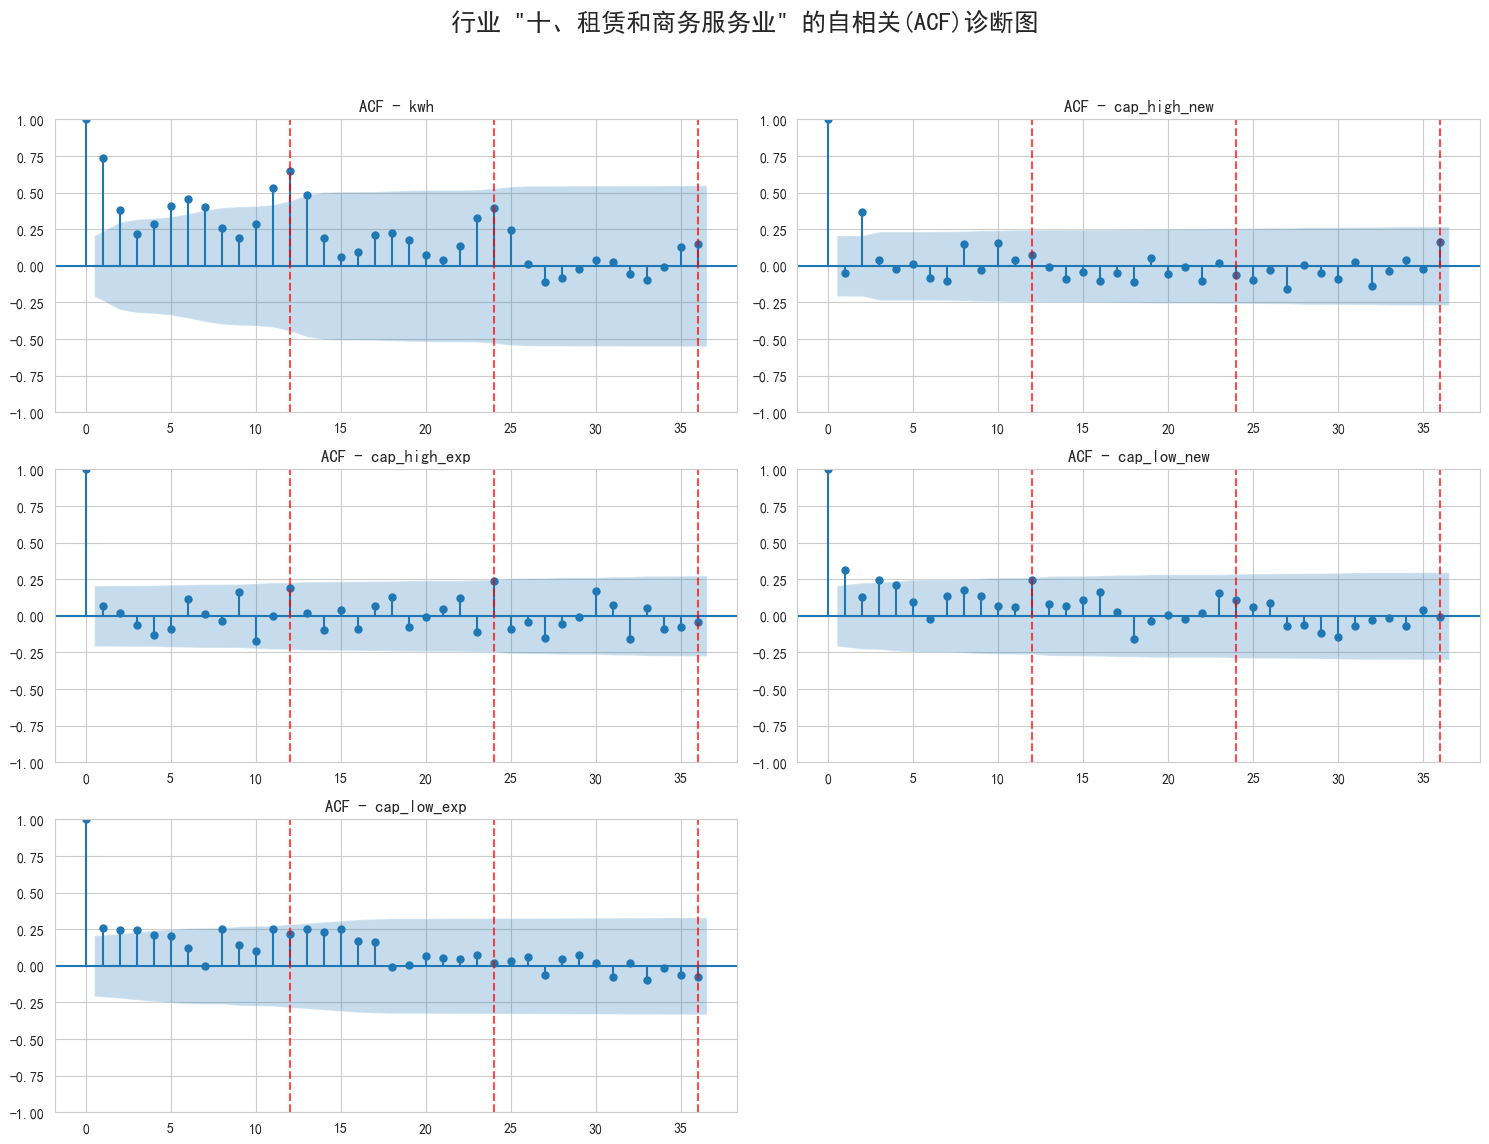


========================= 正在诊断行业: 九、房地产业 =========================


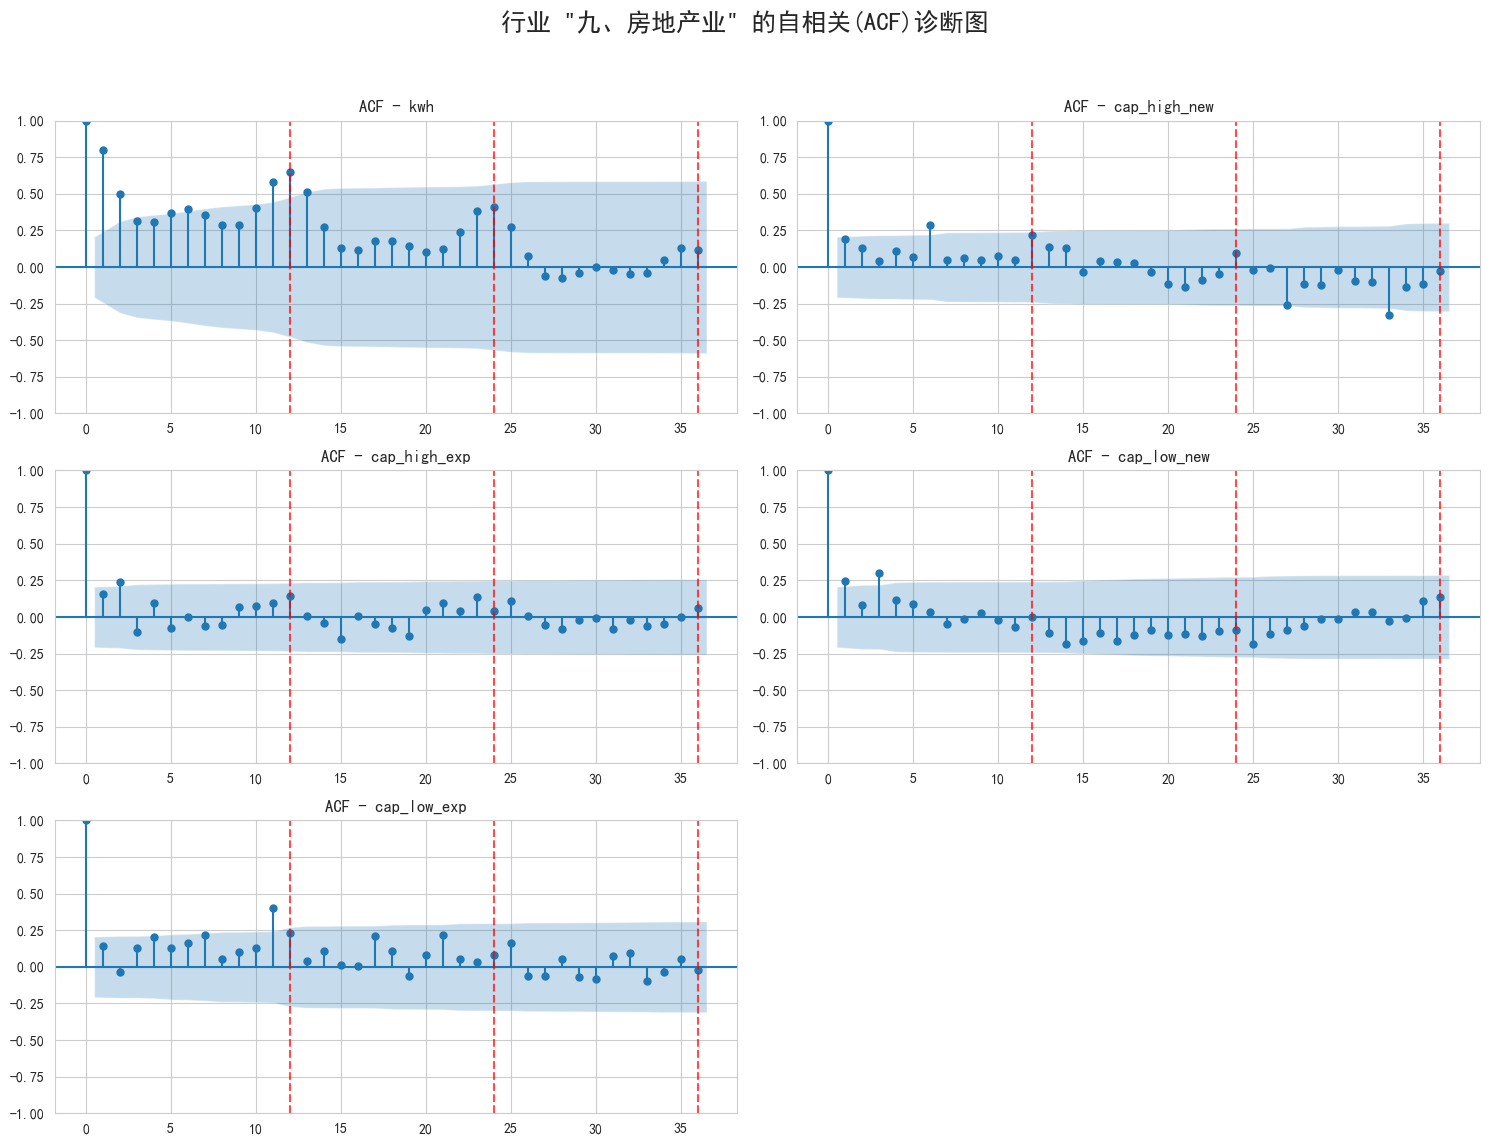


========================= 正在诊断行业: 八、金融业 =========================


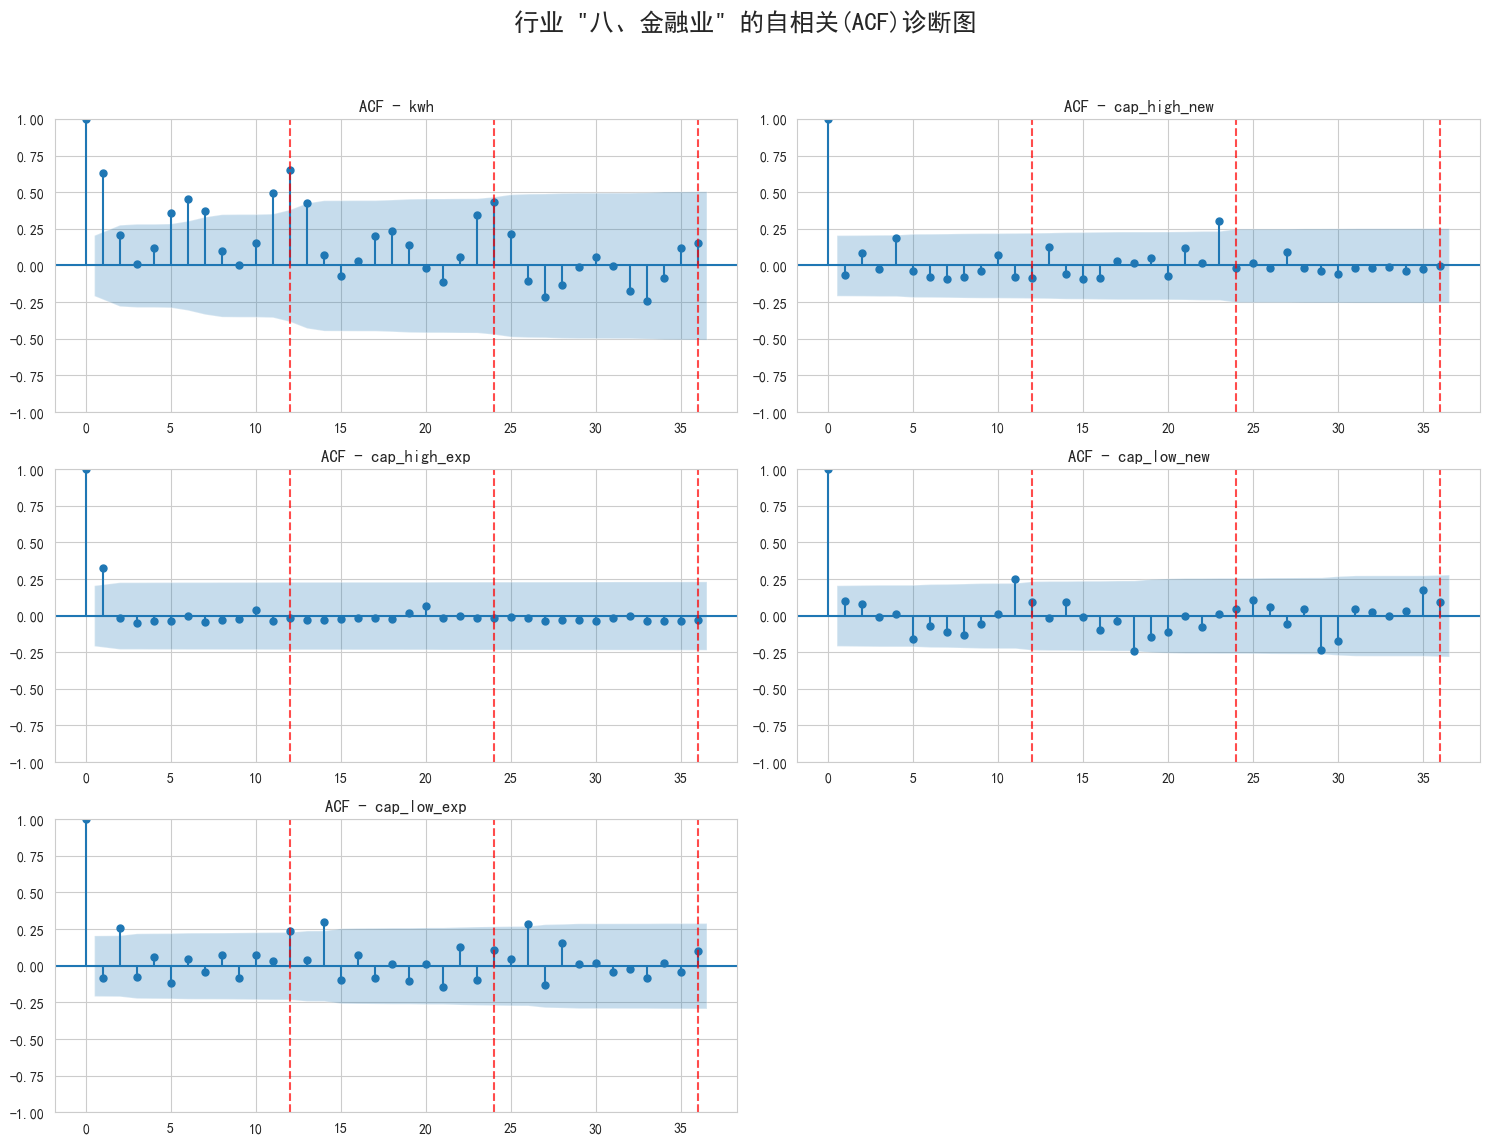


========================= 正在诊断行业:     21.金属制品业 =========================


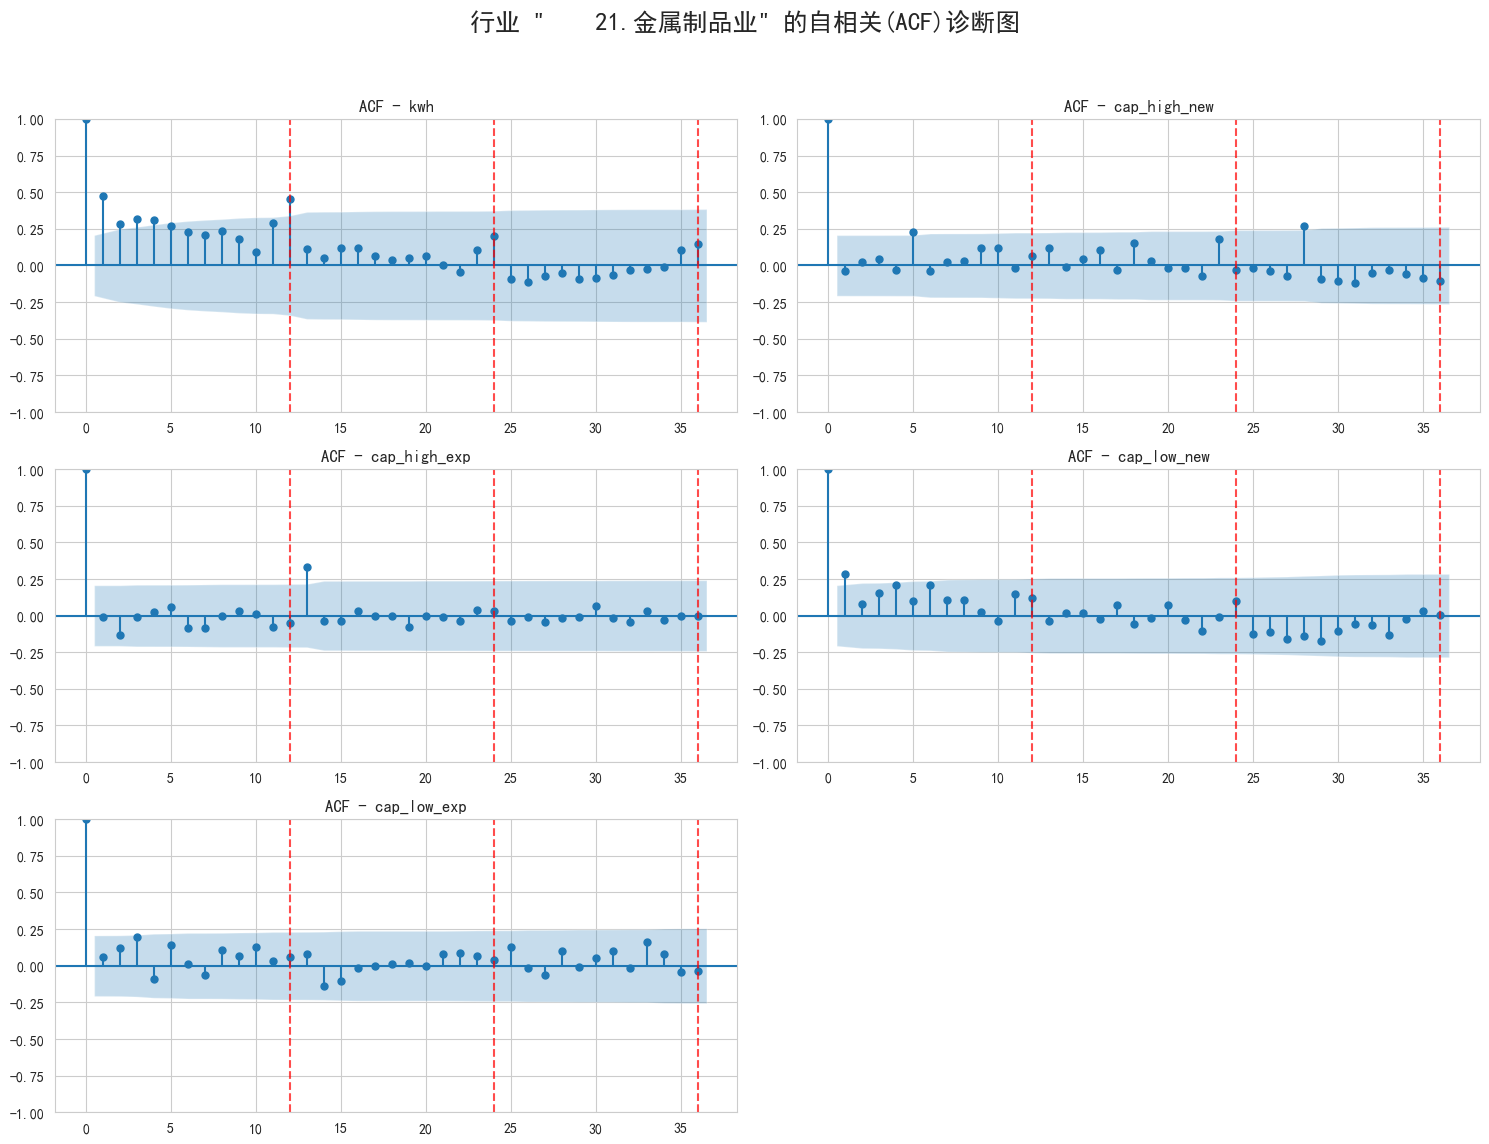


========================= 正在诊断行业:     19.黑色金属冶炼和压延加工业 =========================


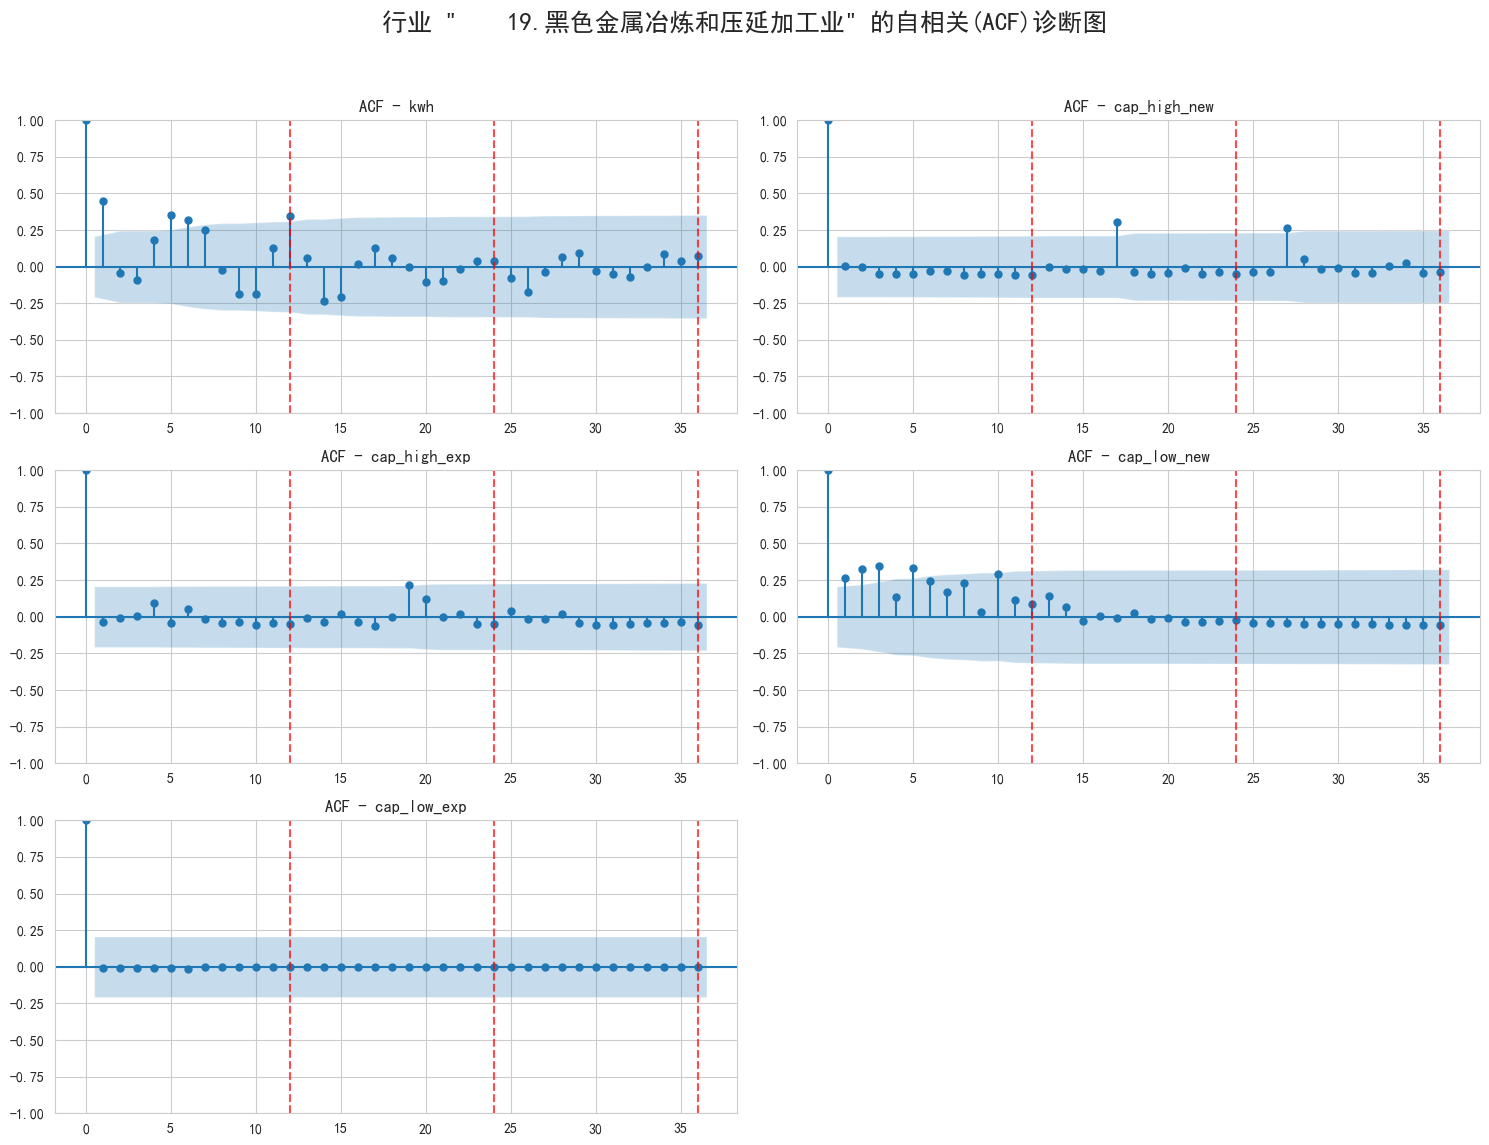

In [39]:
# Cell 3: 定义诊断函数并选择行业

def diagnose_seasonality_for_industry(industry_name, all_data):
    """
    为指定行业的所有平稳序列绘制ACF图，以诊断残余季节性。
    """
    print(f"\n{'='*25} 正在诊断行业: {industry_name} {'='*25}")
    
    # 构建该行业的专属数据集
    industry_df = pd.DataFrame()
    for var_name, df_wide in all_data.items():
        if industry_name in df_wide.index:
            series_raw = df_wide.loc[industry_name]
            ts = pd.Series(
                pd.to_numeric(series_raw, errors='coerce').fillna(0).values,
                index=pd.to_datetime(series_raw.index, format='%Y%m'),
                name=var_name
            )
            industry_df[var_name] = ts
    
    if industry_df.empty:
        print("    -> 未找到该行业数据。")
        return

    # 创建一个2x3的子图布局来展示ACF图
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle(f'行业 "{industry_name}" 的自相关(ACF)诊断图', fontsize=18)
    axes = axes.flatten() # 将2D数组展平为1D，方便循环

    plot_idx = 0
    for col in industry_df.columns:
        ax = axes[plot_idx]
        # 绘制ACF图，lags=36可以观察到3个年度周期
        plot_acf(industry_df[col].dropna(), ax=ax, lags=36, title=f'ACF - {col}')
        ax.grid(True)
        # 在12, 24, 36处画红色虚线，以突出季节性位置
        for lag in [12, 24, 36]:
            ax.axvline(x=lag, color='red', linestyle='--', alpha=0.7)
        plot_idx += 1
        
    # 如果子图数量是奇数，隐藏最后一个空的子图
    if len(industry_df.columns) < len(axes):
        for i in range(len(industry_df.columns), len(axes)):
            axes[i].set_visible(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- 选择要诊断的行业 ---
# 优先选择那些在之前结果中出现12个月滞后的行业
industries_to_diagnose = [
    'B、城乡居民生活用电合计',
    '十一、公共服务及管理组织',
    '    14.化学原料和化学制品制造业',
    '    27.计算机、通信和其他电子设备制造业',
    '七、住宿和餐饮业',
    '十、租赁和商务服务业',
    '九、房地产业',
    '八、金融业',
    '    21.金属制品业',
    '    19.黑色金属冶炼和压延加工业'

]

# 循环调用诊断函数
for industry in industries_to_diagnose:
    diagnose_seasonality_for_industry(industry, all_data_wide)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# --- 环境设置 ---
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ==============================================================================
# 0. 参数配置
# ==============================================================================
# 指向您【已经处理好】的数据文件
processed_data_path = r'E:\A智网\业扩分析\8月分析\8.1分析数据.xlsx' 
# 指向您的滞后期结果文件
lags_file_path = r'E:\A智网\业扩分析\8月分析\业扩CCF分析结果.xlsx'

sheet_map = {
    'd_kwh': '电量', # 假设这个sheet里是已处理好的d_kwh
    'cap_high_new': '高压新装容量', # 假设是已差分
    'cap_high_exp': '高压增容容量', # ...
    'cap_low_new': '低压新装容量',  # ...
    'cap_low_exp': '低压增容容量'  # ...
}

# ==============================================================================
# 1. 加载所有已处理好的数据和滞后期结果
# ==============================================================================
print("--- 步骤 1: 正在加载已处理的数据和滞后期结果 ---")

# --- 1.1 加载已处理的数据 ---
all_data_processed = {}
try:
    for var_name, sheet_name in sheet_map.items():
        df = pd.read_excel(processed_data_path, sheet_name=sheet_name)
        df.columns = df.columns.astype(str).str.replace(r'\.0$', '', regex=True)
        df.set_index('分类', inplace=True)
        # 直接使用数据，不再进行任何处理
        all_data_processed[var_name] = df.drop(columns='序号')
except Exception as e:
    raise RuntimeError(f"加载已处理的数据时出错: {e}")
print("  -> 已处理数据加载完成。")

# --- 1.2 加载滞后期结果表 ---
try:
    df_lags = pd.read_excel(lags_file_path, index_col=0)
    df_lags.columns.name = None
    df_lags.index.name = '行业分类'
except FileNotFoundError:
    raise FileNotFoundError(f"滞后期结果文件未找到: {lags_file_path}")
print("  -> 滞后期结果加载完成。")


# ==============================================================================
# 2. 主循环：分行业建立回归模型
# ==============================================================================
print("\n--- 步骤 2: 开始分行业建立回归模型 ---")
all_results_list = []

for industry_name, industry_lags_row in df_lags.iterrows():
    print(f"\n{'='*25} 正在为行业建模: {industry_name} {'='*25}")
    
    # --- 2.1 构建该行业的专属数据集 ---
    industry_df_processed = pd.DataFrame()
    for var_name, df_wide in all_data_processed.items():
        if industry_name in df_wide.index:
            series_raw = df_wide.loc[industry_name]
            ts = pd.Series(
                pd.to_numeric(series_raw, errors='coerce'),
                index=pd.to_datetime(series_raw.index, format='%Y%m'),
                name=var_name
            )
            industry_df_processed[var_name] = ts

    if industry_df_processed.empty:
        print("    -> 数据不完整，跳过。")
        continue



        # --- 新增的诊断代码 ---
    print(f"    -> 原始加载的数据集构建完成。形状: {industry_df.shape}")
    if industry_df.empty:
        print("    -> 数据不完整，跳过。")
        continue
# --------------------


    # --- 2.2 创建滞后变量 ---
    df_model_data = pd.DataFrame({
        'd_kwh': industry_df_processed['d_kwh'] # 因变量
    })
    
    print("    -> 正在根据滞后期表创建自变量:")
    for cap_var, lag in industry_lags_row.items():
        lag = int(lag)
        df_model_data[f'{cap_var}_lag{lag}'] = industry_df_processed[cap_var].shift(lag)
        print(f"       - {cap_var} 使用滞后期: {lag}")

    df_model_data.dropna(inplace=True)

    if len(df_model_data) < 30:
        print("    -> 数据点不足 (< 30)，无法建立可靠模型，跳过。")
        continue

    # --- 2.3 建立并拟合OLS模型 ---
    Y = df_model_data['d_kwh']
    X = df_model_data.drop(columns='d_kwh')
    X = sm.add_constant(X)
    
    model = sm.OLS(Y, X)
    results = model.fit()
    
    # --- 2.4 提取结果 ---
    industry_results = {'行业分类': industry_name, 'R-squared_adj': results.rsquared_adj}
    for var in X.columns:
        if var != 'const':
            beta_col_name = f'β_{var.split("_lag")[0]}'
            pval_col_name = f'p_{var.split("_lag")[0]}'
            industry_results[beta_col_name] = results.params[var]
            industry_results[pval_col_name] = results.pvalues[var]
    
    all_results_list.append(industry_results)
    print(f"    -> 建模完成。调整后R²: {results.rsquared_adj:.3f}")

# ==============================================================================
# 3. 最终结果汇总与分析
# ==============================================================================
# (这部分代码与上一版本完全相同，此处省略以保持简洁)
# ...
print(f"\n{'='*30} 所有行业回归结果汇总 {'='*30}")
if not all_results_list:
    print("未能完成任何行业的建模。")
else:
    df_regression_summary = pd.DataFrame(all_results_list).set_index('行业分类')
    beta_columns = [col for col in df_regression_summary.columns if col.startswith('β_')]
    df_betas = df_regression_summary[beta_columns].copy()
    df_betas.columns = [col.replace('β_', '') for col in beta_columns]
    df_betas.columns.name = '业扩指标'
    print("\n各行业业扩指标对电量的影响系数 (β值 - kWh/kVA):")
    pvalue_columns = [col for col in df_regression_summary.columns if col.startswith('p_')]
    def highlight_significant(val, p_val):
        return 'font-weight: bold; color: green' if p_val < 0.1 else 'color: grey'
    styled_betas = df_betas.style.format("{:.2f}")
    for p_col in pvalue_columns:
        beta_col_name = p_col.replace('p_', '')
        styled_betas = styled_betas.apply(
            lambda x: pd.Series(index=x.index, data=[highlight_significant(v, p) for v,p in zip(x, df_regression_summary[p_col])]),
            subset=[beta_col_name],
            axis=0
        )
    display(styled_betas) # 在Jupyter中需要导入 display: from IPython.display import display
    # (可选) 保存详细结果和β系数表到Excel
    output_summary_path = r'E:\A智网\业扩分析\8月分析\分行业回归分析结果.xlsx'
    with pd.ExcelWriter(output_summary_path) as writer:
        df_regression_summary.to_excel(writer, sheet_name='详细回归结果')
        df_betas.to_excel(writer, sheet_name='影响系数(β)汇总')
    print(f"\n汇总结果已保存到: {output_summary_path}")

print("\n--- 全部分析任务完成 ---")

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL # 导入STL
from statsmodels.tsa.stattools import ccf
from IPython.display import display
import re

# ==============================================================================
# 0. 参数配置
# ==============================================================================
# 指向您的【原始】数据文件
FILE_PATH = r'E:\A智网\业扩分析\8月分析\报告编制分析\8月上旬电量报告22_25.xlsx' 
# 新的输出文件名，以反映处理方法
OUTPUT_PATH = r'E:\A智网\业扩分析\8月分析\报告编制分析\业扩分析结果_8月上旬电量报告22_25_非净值.xlsx'
SHEET_MAP = {
    'kwh': '电量',
    'cap_high_new': '高压新装',
    'cap_high_exp': '高压增容',
    'cap_low_new': '低压新装',
    'cap_low_exp': '低压增容'
}

# ==============================================================================
# 1. 数据加载与预处理函数 (封装复杂性)
# ==============================================================================
def load_and_prepare_data(file_path, sheet_map):
    """
    加载所有原始数据Sheet，进行清洗和格式转换，返回一个包含所有数据的字典。
    """
    print("--- 步骤 1: 正在加载并预处理所有原始数据 ---")
    all_data = {}
    for var_name, sheet_name in sheet_map.items():
        try:
            df = pd.read_excel(file_path, sheet_name=sheet_name)
            df['分类'] = df['分类'].astype(str).str.strip()
            valid_date_cols = [col for col in df.columns if re.match(r'^\d{6}$', str(col).split('.')[0])]
            df = df[['分类'] + valid_date_cols]
            df_long = df.melt(id_vars='分类', var_name='date', value_name=var_name)
            df_long['date'] = pd.to_datetime(df_long['date'].astype(str), format='%Y%m')
            df_long[var_name] = pd.to_numeric(df_long[var_name], errors='coerce').fillna(0)
            all_data[var_name] = df_long.set_index(['分类', 'date'])
            print(f"  -> Sheet '{sheet_name}' 加载并转换成功。")
        except Exception as e:
            raise RuntimeError(f"处理Sheet '{sheet_name}' 时出错: {e}")
    
    df_full = pd.concat(all_data.values(), axis=1)
    return df_full

# ==============================================================================
# 2. 主分析流程
# ==============================================================================
def run_full_analysis(df_full):
    """
    对加载好的完整数据，分行业进行 预处理 -> CCF -> 回归建模 的完整流程。
    """
    print("\n--- 步骤 2: 开始分行业进行完整分析流程 ---")
    
    industry_list = df_full.index.get_level_values('分类').unique().tolist()
    print(f"将对以下 {len(industry_list)} 个行业进行分析。")
    
    final_results = []

    for industry in industry_list:
        print(f"\n{'='*25} 正在分析: {industry} {'='*25}")
        
        df_industry_raw = df_full.loc[industry]
        
        # --- B. 序列平稳化 (STL + 差分版) ---
        df_processed = pd.DataFrame()
        
        # ★★★★★★★★★★★ 关键修改点 ★★★★★★★★★★★
        # 对电量数据进行STL季节性调整后，再进行一阶差分
        kwh_ts = df_industry_raw['kwh']
        try:
            # 检查数据是否适合进行STL分解
            if len(kwh_ts.dropna()) < 25 or kwh_ts.std() < 1e-6:
                print("    -> 电量数据不足或无波动，仅进行一阶差分。")
                df_processed['d_kwh'] = kwh_ts.diff(1)
            else:
                print("    -> 正在对电量数据进行STL季节性调整...")
                stl = STL(kwh_ts, period=12, robust=True)
                res = stl.fit()
                kwh_seasonally_adjusted = res.trend + res.resid
                df_processed['d_kwh'] = kwh_seasonally_adjusted.diff(1)
                print("    -> STL调整并一阶差分完成。")
                
        except Exception as e:
            print(f"    -> 警告: STL处理失败 ({e})，回退到仅进行一阶差分。")
            df_processed['d_kwh'] = kwh_ts.diff(1)
        # ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

        # 对业扩数据进行一阶差分
        for cap_var in [c for c in df_industry_raw.columns if c != 'kwh']:
            df_processed[cap_var] = df_industry_raw[cap_var].diff(1)
        
        df_processed.dropna(inplace=True)
        
        if len(df_processed) < 30:
            print("    -> 预处理后数据点不足 (< 30)，跳过。")
            continue
        print(f"    -> 数据平稳化完成，剩余 {len(df_processed)} 个有效数据点。")
        
        # --- C. CCF分析确定滞后期 ---
        lags = {}
        exog_vars = [c for c in df_processed.columns if c != 'd_kwh']
        for var in exog_vars:
            ccf_vals = ccf(df_processed['d_kwh'], df_processed[var], adjusted=False)
            relevant_lags = range(1, 9)
            best_lag = relevant_lags[np.argmax(np.abs(ccf_vals[1:9]))]
            lags[var] = best_lag
        print(f"    -> CCF分析完成，最佳滞后期: {lags}")

        # --- D. 回归建模 ---
        df_model = df_processed[['d_kwh']].copy()
        for var, lag in lags.items():
            df_model[f'{var}_lag{lag}'] = df_processed[var].shift(lag)
        df_model.dropna(inplace=True)
        
        if len(df_model) < 25:
            print("    -> 创建滞后变量后数据点不足 (< 25)，跳过。")
            continue
            
        Y = df_model['d_kwh']
        X = df_model.drop(columns='d_kwh')
        X = sm.add_constant(X)
        model_results = sm.OLS(Y, X).fit()
        
        # --- E. 提取结果 ---
        result_row = {'行业分类': industry, 'R-squared_adj': model_results.rsquared_adj}
        for var, lag in lags.items():
            result_row[f'k_{var}'] = lag
            param_name = f'{var}_lag{lag}'
            result_row[f'β_{var}'] = model_results.params.get(param_name, np.nan)
            result_row[f'p_{var}'] = model_results.pvalues.get(param_name, np.nan)
        
        final_results.append(result_row)
        print(f"    -> 回归建模完成，调整后R²: {model_results.rsquared_adj:.3f}")

    return pd.DataFrame(final_results)

# ==============================================================================
# 3. 结果展示与保存
# ==============================================================================
def display_and_save_results(df_summary, output_path):
    if df_summary.empty:
        print("\n未能完成任何行业的分析。")
        return

    print(f"\n{'='*30} 所有行业分析结果汇总 {'='*30}")
    df_summary.set_index('行业分类', inplace=True)

    lag_cols = sorted([c for c in df_summary.columns if c.startswith('k_')])
    df_lags = df_summary[lag_cols].rename(columns=lambda c: c.replace('k_', ''))
    print("\n各行业【最佳影响滞后期(月)】汇总:")
    display(df_lags)
    
    beta_cols = sorted([c for c in df_summary.columns if c.startswith('β_')])
    df_betas = df_summary[beta_cols].rename(columns=lambda c: c.replace('β_', ''))
    print("\n各行业【影响系数(β值 - kWh/kVA)】汇总 (绿色粗体表示统计显著):")
    
    def highlight_significant(x):
        styles = pd.DataFrame('', index=x.index, columns=x.columns)
        for beta_col in x.columns:
            pval_col = 'p_' + beta_col
            if pval_col in df_summary.columns:
                styles[beta_col] = np.where(df_summary[pval_col] < 0.1, 
                                            'font-weight: bold; color: green;', 
                                            'color: grey;')
        return styles

    styled_betas = df_betas.style.format("{:.2f}").apply(highlight_significant, axis=None)
    display(styled_betas)
    
    with pd.ExcelWriter(output_path) as writer:
        df_lags.to_excel(writer, sheet_name='滞后期(k)汇总')
        df_betas.to_excel(writer, sheet_name='影响系数(β)汇总')
        df_summary.to_excel(writer, sheet_name='全部详细结果')
    print(f"\n完整汇总结果已保存到: {output_path}")

# ==============================================================================
# 4. 执行主程序
# ==============================================================================
if __name__ == '__main__':
    # 步骤1: 加载和准备数据
    full_data = load_and_prepare_data(FILE_PATH, SHEET_MAP)
    
    # 步骤2: 运行完整分析流程
    summary_results = run_full_analysis(full_data)
    
    # 步骤3: 展示并保存结果
    display_and_save_results(summary_results, OUTPUT_PATH)

    print("\n--- 全部分析任务完成 ---")

--- 步骤 1: 正在加载并预处理所有原始数据 ---
  -> Sheet '电量' 加载并转换成功。
  -> Sheet '高压新装' 加载并转换成功。
  -> Sheet '高压增容' 加载并转换成功。
  -> Sheet '低压新装' 加载并转换成功。
  -> Sheet '低压增容' 加载并转换成功。

--- 步骤 2: 开始分行业进行完整分析流程 ---
将对以下 6 个行业进行分析。

========================= 正在分析: 全行业总计 =========================
    -> 正在对电量数据进行STL季节性调整...
    -> STL调整并一阶差分完成。
    -> 数据平稳化完成，剩余 42 个有效数据点。
    -> CCF分析完成，最佳滞后期: {'cap_high_new': 3, 'cap_high_exp': 1, 'cap_low_new': 6, 'cap_low_exp': 5}
    -> 回归建模完成，调整后R²: 0.187

========================= 正在分析: A、全行业用电合计 =========================
    -> 正在对电量数据进行STL季节性调整...
    -> STL调整并一阶差分完成。
    -> 数据平稳化完成，剩余 42 个有效数据点。
    -> CCF分析完成，最佳滞后期: {'cap_high_new': 5, 'cap_high_exp': 1, 'cap_low_new': 2, 'cap_low_exp': 5}
    -> 回归建模完成，调整后R²: 0.171

========================= 正在分析: 第一产业 =========================
    -> 正在对电量数据进行STL季节性调整...
    -> STL调整并一阶差分完成。
    -> 数据平稳化完成，剩余 42 个有效数据点。
    -> CCF分析完成，最佳滞后期: {'cap_high_new': 6, 'cap_high_exp': 7, 'cap_low_new': 7, 'cap_low_exp': 4}
    -> 回归建模完成，调整

,cap_high_exp,cap_high_new,cap_low_exp,cap_low_new
行业分类,,,,
全行业总计,1,3,5,6
A、全行业用电合计,1,5,5,2
第一产业,7,6,4,7
第二产业,5,8,7,5
第三产业,8,2,2,3
B、城乡居民生活用电合计,5,3,2,2



各行业【影响系数(β值 - kWh/kVA)】汇总 (绿色粗体表示统计显著):


,cap_high_exp,cap_high_new,cap_low_exp,cap_low_new
行业分类,,,,
全行业总计,0.07,-0.01,-3.82,0.03
A、全行业用电合计,0.11,0.01,-8.77,-0.09
第一产业,-0.22,-0.03,-0.29,0.03
第二产业,0.08,-0.04,-31.85,0.58
第三产业,-0.12,-0.02,-0.18,-0.06
B、城乡居民生活用电合计,1.65,0.61,3.24,0.02



完整汇总结果已保存到: E:\A智网\业扩分析\8月分析\报告编制分析\业扩分析结果_8月上旬电量报告22_25_非净值.xlsx

--- 全部分析任务完成 ---


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL # 导入STL
from statsmodels.tsa.stattools import ccf
from IPython.display import display
import re

# ==============================================================================
# 0. 参数配置
# ==============================================================================
# 指向您的【原始】数据文件
FILE_PATH = r'E:\A智网\业扩分析\8月分析\报告编制分析\8月上旬电量报告22_25_净值.xlsx' 
# 新的输出文件名，以反映处理方法
OUTPUT_PATH = r'E:\A智网\业扩分析\8月分析\报告编制分析\8月上旬电量报告22_25_业扩分析结果.xlsx'
SHEET_MAP = {
    'kwh': '电量',
    'cap_high_new': '高压净新装',
    'cap_high_exp': '高压净增容',
    'cap_low_new': '低压净新装',
    'cap_low_exp': '低压净增容'
}

# ==============================================================================
# 1. 数据加载与预处理函数 (封装复杂性)
# ==============================================================================
def load_and_prepare_data(file_path, sheet_map):
    """
    加载所有原始数据Sheet，进行清洗和格式转换，返回一个包含所有数据的字典。
    """
    print("--- 步骤 1: 正在加载并预处理所有原始数据 ---")
    all_data = {}
    for var_name, sheet_name in sheet_map.items():
        try:
            df = pd.read_excel(file_path, sheet_name=sheet_name)
            df['分类'] = df['分类'].astype(str).str.strip()
            valid_date_cols = [col for col in df.columns if re.match(r'^\d{6}$', str(col).split('.')[0])]
            df = df[['分类'] + valid_date_cols]
            df_long = df.melt(id_vars='分类', var_name='date', value_name=var_name)
            df_long['date'] = pd.to_datetime(df_long['date'].astype(str), format='%Y%m')
            df_long[var_name] = pd.to_numeric(df_long[var_name], errors='coerce').fillna(0)
            all_data[var_name] = df_long.set_index(['分类', 'date'])
            print(f"  -> Sheet '{sheet_name}' 加载并转换成功。")
        except Exception as e:
            raise RuntimeError(f"处理Sheet '{sheet_name}' 时出错: {e}")
    
    df_full = pd.concat(all_data.values(), axis=1)
    return df_full

# ==============================================================================
# 2. 主分析流程
# ==============================================================================
def run_full_analysis(df_full):
    """
    对加载好的完整数据，分行业进行 预处理 -> CCF -> 回归建模 的完整流程。
    """
    print("\n--- 步骤 2: 开始分行业进行完整分析流程 ---")
    
    industry_list = df_full.index.get_level_values('分类').unique().tolist()
    print(f"将对以下 {len(industry_list)} 个行业进行分析。")
    
    final_results = []

    for industry in industry_list:
        print(f"\n{'='*25} 正在分析: {industry} {'='*25}")
        
        df_industry_raw = df_full.loc[industry]
        
        # --- B. 序列平稳化 (STL + 差分版) ---
        df_processed = pd.DataFrame()
        
        # ★★★★★★★★★★★ 关键修改点 ★★★★★★★★★★★
        # 对电量数据进行STL季节性调整后，再进行一阶差分
        kwh_ts = df_industry_raw['kwh']
        try:
            # 检查数据是否适合进行STL分解
            if len(kwh_ts.dropna()) < 25 or kwh_ts.std() < 1e-6:
                print("    -> 电量数据不足或无波动，仅进行一阶差分。")
                df_processed['d_kwh'] = kwh_ts.diff(1)
            else:
                print("    -> 正在对电量数据进行STL季节性调整...")
                stl = STL(kwh_ts, period=12, robust=True)
                res = stl.fit()
                kwh_seasonally_adjusted = res.trend + res.resid
                df_processed['d_kwh'] = kwh_seasonally_adjusted.diff(1)
                print("    -> STL调整并一阶差分完成。")
                
        except Exception as e:
            print(f"    -> 警告: STL处理失败 ({e})，回退到仅进行一阶差分。")
            df_processed['d_kwh'] = kwh_ts.diff(1)
        # ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

        # 对业扩数据进行一阶差分
        for cap_var in [c for c in df_industry_raw.columns if c != 'kwh']:
            df_processed[cap_var] = df_industry_raw[cap_var].diff(1)
        
        df_processed.dropna(inplace=True)
        
        if len(df_processed) < 30:
            print("    -> 预处理后数据点不足 (< 30)，跳过。")
            continue
        print(f"    -> 数据平稳化完成，剩余 {len(df_processed)} 个有效数据点。")
        
        # --- C. CCF分析确定滞后期 ---
        lags = {}
        exog_vars = [c for c in df_processed.columns if c != 'd_kwh']
        for var in exog_vars:
            ccf_vals = ccf(df_processed['d_kwh'], df_processed[var], adjusted=False)
            relevant_lags = range(1, 9)
            best_lag = relevant_lags[np.argmax(np.abs(ccf_vals[1:9]))]
            lags[var] = best_lag
        print(f"    -> CCF分析完成，最佳滞后期: {lags}")

        # --- D. 回归建模 ---
        df_model = df_processed[['d_kwh']].copy()
        for var, lag in lags.items():
            df_model[f'{var}_lag{lag}'] = df_processed[var].shift(lag)
        df_model.dropna(inplace=True)
        
        if len(df_model) < 25:
            print("    -> 创建滞后变量后数据点不足 (< 25)，跳过。")
            continue
            
        Y = df_model['d_kwh']
        X = df_model.drop(columns='d_kwh')
        X = sm.add_constant(X)
        model_results = sm.OLS(Y, X).fit()
        
        # --- E. 提取结果 ---
        result_row = {'行业分类': industry, 'R-squared_adj': model_results.rsquared_adj}
        for var, lag in lags.items():
            result_row[f'k_{var}'] = lag
            param_name = f'{var}_lag{lag}'
            result_row[f'β_{var}'] = model_results.params.get(param_name, np.nan)
            result_row[f'p_{var}'] = model_results.pvalues.get(param_name, np.nan)
        
        final_results.append(result_row)
        print(f"    -> 回归建模完成，调整后R²: {model_results.rsquared_adj:.3f}")

    return pd.DataFrame(final_results)

# ==============================================================================
# 3. 结果展示与保存
# ==============================================================================
def display_and_save_results(df_summary, output_path):
    if df_summary.empty:
        print("\n未能完成任何行业的分析。")
        return

    print(f"\n{'='*30} 所有行业分析结果汇总 {'='*30}")
    df_summary.set_index('行业分类', inplace=True)

    lag_cols = sorted([c for c in df_summary.columns if c.startswith('k_')])
    df_lags = df_summary[lag_cols].rename(columns=lambda c: c.replace('k_', ''))
    print("\n各行业【最佳影响滞后期(月)】汇总:")
    display(df_lags)
    
    beta_cols = sorted([c for c in df_summary.columns if c.startswith('β_')])
    df_betas = df_summary[beta_cols].rename(columns=lambda c: c.replace('β_', ''))
    print("\n各行业【影响系数(β值 - kWh/kVA)】汇总 (绿色粗体表示统计显著):")
    
    def highlight_significant(x):
        styles = pd.DataFrame('', index=x.index, columns=x.columns)
        for beta_col in x.columns:
            pval_col = 'p_' + beta_col
            if pval_col in df_summary.columns:
                styles[beta_col] = np.where(df_summary[pval_col] < 0.1, 
                                            'font-weight: bold; color: green;', 
                                            'color: grey;')
        return styles

    styled_betas = df_betas.style.format("{:.2f}").apply(highlight_significant, axis=None)
    display(styled_betas)
    
    with pd.ExcelWriter(output_path) as writer:
        df_lags.to_excel(writer, sheet_name='滞后期(k)汇总')
        df_betas.to_excel(writer, sheet_name='影响系数(β)汇总')
        df_summary.to_excel(writer, sheet_name='全部详细结果')
    print(f"\n完整汇总结果已保存到: {output_path}")

# ==============================================================================
# 4. 执行主程序
# ==============================================================================
if __name__ == '__main__':
    # 步骤1: 加载和准备数据
    full_data = load_and_prepare_data(FILE_PATH, SHEET_MAP)
    
    # 步骤2: 运行完整分析流程
    summary_results = run_full_analysis(full_data)
    
    # 步骤3: 展示并保存结果
    display_and_save_results(summary_results, OUTPUT_PATH)

    print("\n--- 全部分析任务完成 ---")

--- 步骤 1: 正在加载并预处理所有原始数据 ---
  -> Sheet '电量' 加载并转换成功。
  -> Sheet '高压净新装' 加载并转换成功。
  -> Sheet '高压净增容' 加载并转换成功。
  -> Sheet '低压净新装' 加载并转换成功。
  -> Sheet '低压净增容' 加载并转换成功。

--- 步骤 2: 开始分行业进行完整分析流程 ---
将对以下 6 个行业进行分析。

========================= 正在分析: 全行业总计 =========================
    -> 正在对电量数据进行STL季节性调整...
    -> STL调整并一阶差分完成。
    -> 数据平稳化完成，剩余 42 个有效数据点。
    -> CCF分析完成，最佳滞后期: {'cap_high_new': 3, 'cap_high_exp': 1, 'cap_low_new': 6, 'cap_low_exp': 5}
    -> 回归建模完成，调整后R²: 0.116

========================= 正在分析: A、全行业用电合计 =========================
    -> 正在对电量数据进行STL季节性调整...
    -> STL调整并一阶差分完成。
    -> 数据平稳化完成，剩余 42 个有效数据点。
    -> CCF分析完成，最佳滞后期: {'cap_high_new': 5, 'cap_high_exp': 1, 'cap_low_new': 2, 'cap_low_exp': 5}
    -> 回归建模完成，调整后R²: 0.104

========================= 正在分析: 第一产业 =========================
    -> 正在对电量数据进行STL季节性调整...
    -> STL调整并一阶差分完成。
    -> 数据平稳化完成，剩余 42 个有效数据点。
    -> CCF分析完成，最佳滞后期: {'cap_high_new': 6, 'cap_high_exp': 7, 'cap_low_new': 7, 'cap_low_exp': 4}
    -> 回归建模完

,cap_high_exp,cap_high_new,cap_low_exp,cap_low_new
行业分类,,,,
全行业总计,1,3,5,6
A、全行业用电合计,1,5,5,2
第一产业,7,6,4,7
第二产业,3,6,7,5
第三产业,8,2,2,3
B、城乡居民生活用电合计,5,1,2,2



各行业【影响系数(β值 - kWh/kVA)】汇总 (绿色粗体表示统计显著):


,cap_high_exp,cap_high_new,cap_low_exp,cap_low_new
行业分类,,,,
全行业总计,0.09,-0.00,-0.27,0.07
A、全行业用电合计,0.14,0.00,-0.06,-0.06
第一产业,-0.21,-0.04,-0.25,0.03
第二产业,-0.13,0.01,-1.28,0.59
第三产业,-0.14,-0.02,0.17,-0.06
B、城乡居民生活用电合计,1.23,0.29,1.67,0.04



完整汇总结果已保存到: E:\A智网\业扩分析\8月分析\报告编制分析\8月上旬电量报告22_25_业扩分析结果.xlsx

--- 全部分析任务完成 ---
